In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def generate_sobel_kernel(kSize):
    if kSize % 2 == 0:
        raise ValueError("Kernel size must be odd")
    # kernel y = kernel x transpose
    kernel_x = np.zeros((kSize, kSize), dtype=np.float32)
    kernel_x[:,0] = -1
    kernel_x[:,-1] = 1
    for i in range(1, kSize - 1):
        kernel_x[i, 0] = -2
        kernel_x[i, -1] = 2
    kernel_y = kernel_x.T
    return kernel_x, kernel_y

def getGradient(image, kSize=3):
    kernel_x, kernel_y = generate_sobel_kernel(kSize)
    image = image.astype(np.float32)
    pad = kSize // 2
    padded_image = np.pad(image, pad, mode = 'reflect')
    # 套用 kernel_x, kernel_y
    gradient_x = np.zeros_like(image)
    gradient_y = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            gradient_x[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_x)
            gradient_y[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_y)
    return gradient_x, gradient_y
# Canny
def canny(image, kSize=3, weak=75, strong=255):
    gradient_x, gradient_y = getGradient(image)
    # 找出梯度的大小跟方向
    gra_mag = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    gra_dir = np.arctan2(gradient_y, gradient_x)
    supressed = np.zeros_like(gra_mag)
    # non-maxima supression, 保留邊緣點
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            angle = gra_dir[i, j]
            mag = gra_mag[i, j]
            
            # 旋轉角度, 0 ~ 180
            angle = angle * 180 / np.pi
            if angle < 0:
                angle += 180
            
            # 看看自己的鄰居, 僅保留最大的鄰居
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbors = [gra_mag[i, j-1], gra_mag[i, j+1]]
            elif 22.5 <= angle < 67.5:
                neighbors = [gra_mag[i-1, j-1], gra_mag[i+1, j+1]]
            elif 67.5 <= angle < 112.5:
                neighbors = [gra_mag[i-1, j], gra_mag[i+1, j]]
            else:
                neighbors = [gra_mag[i-1, j+1], gra_mag[i+1, j-1]]
            if mag >= max(neighbors):
                supressed[i,j] = mag
    # 兩個 threshold, 來找出強強邊緣跟弱邊緣點
    # numpy 好好用!
    result_image = np.zeros_like(supressed, dtype=np.uint8)
    strong_i, strong_j = np.where(supressed >= strong)
    weak_i, weak_j = np.where((supressed >= weak) & (supressed < strong))
    result_image[strong_i, strong_j] = strong
    result_image[weak_i, weak_j] = weak
    # 邊緣追蹤
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if result_image[i, j] == weak:
                # 檢查弱邊緣周圍八個點有沒有強邊緣, 有的話就保留
                if strong in [result_image[i+ii, j+jj] for ii in [-1, 0, 1] for jj in [-1, 0, 1]]:
                    result_image[i, j] = 255
                else:
                    result_image[i, j] = 0
    return result_image


In [5]:
def rotate_image(image, angle):
    h, w = image.shape
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return rotated

def create_r_table(image, kSize=3, angle_step=1):
    r_table = {}
    mid_point = (image.shape[0] // 2, image.shape[1] // 2)
    for angle in range(0, 360, angle_step):
        # 旋轉圖片, 獲取梯度強度, 方向
        rotated_image = rotate_image(image, angle)
        gradient_x, gradient_y = getGradient(rotated_image, kSize)
        magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        direction = np.arctan2(gradient_y, gradient_x)

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if magnitude[i, j] > 0:  # 邊緣點
                    theta = direction[i, j]
                    # 向量
                    r = (j - mid_point[0], i - mid_point[1])
                    theta_bin = round(theta / np.pi * 180)

                    if angle not in r_table:
                        r_table[angle] = {}
                    if theta_bin not in r_table[angle]:
                        r_table[angle][theta_bin] = []
                    r_table[angle][theta_bin].append(r)
    return r_table

def detect_object(image, r_table, kSize=3, angle_step=1):
    gradient_x, gradient_y = getGradient(image, kSize)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    direction = np.arctan2(gradient_y, gradient_x)

    accumulator = np.zeros((*image.shape, len(range(0, 360, angle_step))), dtype=np.int32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if magnitude[i, j] > 0:
                theta = direction[i, j]
                theta_bin = round(theta / np.pi * 180)

                for angle_idx, angle in enumerate(range(0, 360, angle_step)):
                    if angle in r_table and theta_bin in r_table[angle]:
                        for r in r_table[angle][theta_bin]:
                            x_c = j - r[0]
                            y_c = i - r[1]
                            if 0 <= x_c < image.shape[1] and 0 <= y_c < image.shape[0]:
                                accumulator[y_c, x_c, angle_idx] += 1
    return accumulator
def display_result(image, accumulator, angle_step=1):
    y, x, angle_idx = np.unravel_index(np.argmax(accumulator), accumulator.shape)
    angle = angle_idx * angle_step

    result_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.circle(result_image, (x, y), 10, (0, 0, 255), 2)
    plt.imshow(result_image)
    plt.title(f"Detected Object Center (Angle: {angle} degrees)")
    plt.axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


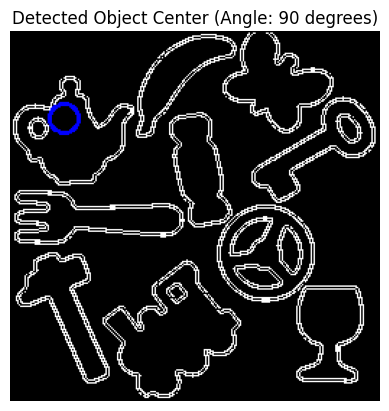

In [7]:

def main():
    angle_step = 45
    # 讀取處理後的圖片
    image = cv2.imread('Reference.png', cv2.IMREAD_GRAYSCALE)
    template = cv2.imread('Template2.png', cv2.IMREAD_GRAYSCALE)
    image = canny(image)
    template = canny(template)
    
    r_table = create_r_table(template, angle_step=angle_step)
    # 在 image 當中找 r_table 標示出的特徵
    
    result = np.array(image, dtype=np.float32)
    accumlator = detect_object(result, r_table, angle_step=angle_step)
    display_result(result, accumlator, angle_step=angle_step)

if __name__ == '__main__':
    main()